In [47]:
!pip install seaborn
!pip install captum
!pip install seaborn

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [49]:
dataset=sb.load_dataset('flights')
print(dataset.head(12))
print(len(dataset))

    year month  passengers
0   1949   Jan         112
1   1949   Feb         118
2   1949   Mar         132
3   1949   Apr         129
4   1949   May         121
5   1949   Jun         135
6   1949   Jul         148
7   1949   Aug         148
8   1949   Sep         136
9   1949   Oct         119
10  1949   Nov         104
11  1949   Dec         118
144


In [50]:
#from that we build our own training data with a sliding window of length 10
targets,features=[],[]
for i in range(10,len(dataset)):
  target=dataset['passengers'][i]
  targets.append(target)
  feature=dataset['passengers'][i-10:i]
  features.append(feature)


feature_tensor=torch.Tensor(features).float()
target_tensor=torch.Tensor(targets).float()

In [51]:
#normalize the data
mean_f=torch.mean(feature_tensor)
std_f=torch.std(feature_tensor)
feature_tensor=(feature_tensor-mean_f)/std_f

mean_t=torch.mean(target_tensor)
std_t=torch.std(target_tensor)
target_tensor=(target_tensor-mean_f)/std_f

In [52]:
#randomly split training and test set
training_part=round(len(feature_tensor)*0.9)
print(training_part)

shuffled_index=torch.randperm(len(features))
training_index=shuffled_index[:training_part]
validation_index=shuffled_index[training_part:len(feature_tensor)]


train_f,train_t=feature_tensor[training_index],target_tensor[training_index]
val_f,val_t=feature_tensor[validation_index],target_tensor[validation_index]

121


In [53]:
#define a network, loss function and optimizer

class RegModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin1=nn.Linear(10,3)
    self.sig1=nn.Sigmoid()
    self.lin2=nn.Linear(3,1)

  def forward(self,x):
    z=self.lin1(x)
    z=self.sig1(z)
    z=self.lin2(z)
    return z

model=RegModel()
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(),lr=0.00001)

In [54]:
import copy
epochs=150000
best_val_loss=10**10

for epoch in range(epochs):
  pred=model(train_f).squeeze()
  loss=loss_func(pred,train_t)
  loss.backward()
  opt.step()

  #calculate validation loss
  val_loss=loss_func(model(val_f).squeeze(),val_t)

  if val_loss<best_val_loss:
    best_val_loss=val_loss
    best_model=copy.deepcopy(model)
    inc_count=0
  else:
    inc_count+=1
  if inc_count >225:
    model=best_model
    break

  model.zero_grad()
  if epoch%(epochs/100) == 0:
    print('training loss: ',loss,'  validation loss: ',val_loss)


training loss:  tensor(1.3322, grad_fn=<MseLossBackward>)   validation loss:  tensor(1.5512, grad_fn=<MseLossBackward>)
training loss:  tensor(1.2568, grad_fn=<MseLossBackward>)   validation loss:  tensor(1.4812, grad_fn=<MseLossBackward>)
training loss:  tensor(1.1882, grad_fn=<MseLossBackward>)   validation loss:  tensor(1.4245, grad_fn=<MseLossBackward>)
training loss:  tensor(1.1235, grad_fn=<MseLossBackward>)   validation loss:  tensor(1.3687, grad_fn=<MseLossBackward>)
training loss:  tensor(1.0599, grad_fn=<MseLossBackward>)   validation loss:  tensor(1.3064, grad_fn=<MseLossBackward>)
training loss:  tensor(0.9971, grad_fn=<MseLossBackward>)   validation loss:  tensor(1.2423, grad_fn=<MseLossBackward>)
training loss:  tensor(0.9363, grad_fn=<MseLossBackward>)   validation loss:  tensor(1.1794, grad_fn=<MseLossBackward>)
training loss:  tensor(0.8779, grad_fn=<MseLossBackward>)   validation loss:  tensor(1.1182, grad_fn=<MseLossBackward>)
training loss:  tensor(0.8225, grad_fn=<

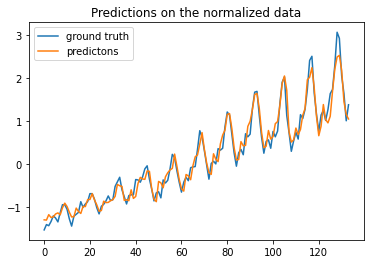

In [55]:
#visualize model performance

full_predictions=model(feature_tensor).detach()

import matplotlib.pyplot as plt

plt.plot(target_tensor,label='ground truth')
plt.plot(full_predictions,label='predictons')
plt.title('Predictions on the normalized data')
plt.legend()
plt.show()

In [56]:
#try some captum methods on the model
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

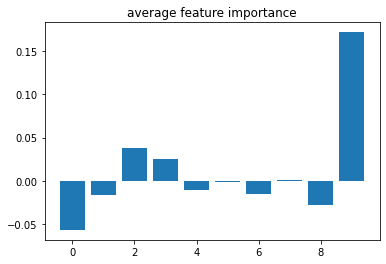

In [57]:
intgrad = IntegratedGradients(model)
feature_tensor.requires_grad_()
attr, delta = intgrad.attribute(feature_tensor, return_convergence_delta=True)
attr = attr.detach().numpy()

importance=np.mean(attr,axis=0)

x_i=np.arange(len(importance))

plt.bar(x_i,importance)
plt.title('average feature importance')
plt.show()

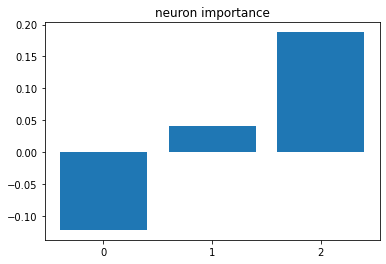

In [58]:
cond = LayerConductance(model, model.lin1)
cond_vals = cond.attribute(feature_tensor)
cond_vals = cond_vals.detach().numpy()
cond_vals = np.mean(cond_vals,axis=0)

x_i=np.arange(len(cond_vals))
plt.bar(x_i,cond_vals)
plt.title('neuron importance')
plt.xticks(x_i)
plt.show()

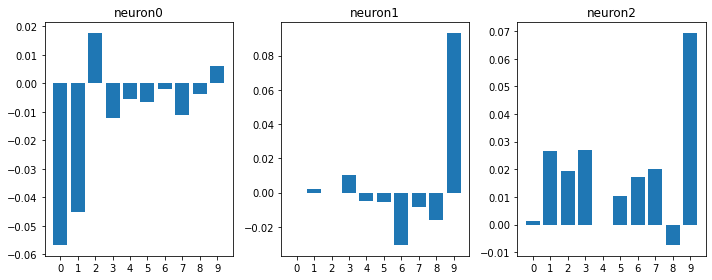

In [59]:
#lets look closer at the neurons
fig = plt.figure(figsize=(10, 4))

for neuron_index in range(3):

  neuron_cond = NeuronConductance(model, model.lin1)
  neuron0_cond = neuron_cond.attribute(feature_tensor, 
                                       neuron_selector=neuron_index)
  neuron0_cond = np.mean(neuron0_cond.detach().numpy(),axis=0)

  plt.subplot(130+neuron_index+1)
  x_i=np.arange(len(neuron0_cond))
  plt.bar(x_i,neuron0_cond)
  plt.title('neuron'+str(neuron_index))
  plt.xticks(x_i)

plt.tight_layout()
plt.show()

So here we can see that for neuron 1 and 2 the feature 10 is most imoprtant. These two neurons have little to no negative correlation to the inputs, while neuron0 almost exclusively has negative correlations to the input. Also considering the figure "neuron importance" from before, it seems as if neuron 0 is focussing on predicting a decrease, while the other two have learned features that predict an increase in the passenger numbers.

The main takeaway is that input 10 is the most important positive correlation for the output. That may be because the number of recorded flight passengers  most of the time was around the number of the month before.


In [60]:
def get_attr(model,input):
  model.eval()
  ig = IntegratedGradients(model)
  attributions, delta = ig.attribute(input, torch.zeros(1,10),
                                     return_convergence_delta=True)
  return attributions,delta
  
#test
attributions,delta=get_attr(model,torch.rand(1,10))
print('IG Attributions:', attributions)
print('Convergence Delta:', delta)

IG Attributions: tensor([[ 0.3932,  0.0667, -0.2913, -0.0217, -0.0007,  0.2839, -0.1313, -0.0343,
         -0.1947,  0.1034]], dtype=torch.float64)
Convergence Delta: tensor([-6.0856e-08], dtype=torch.float64)


In [61]:
#define a function to visualize the attributions for the inputs
#note that in this function we make use of the error-indicators

def viz_input_importance(x,y,attributions,magnify_factor=1):
  attributions=attributions.squeeze().detach().numpy()
  yerr = np.abs(attributions)*magnify_factor

  # manipulate lower & upper limits 
  lowlim = np.array([attributions > 0]).reshape(10,)
  uplim = np.array([attributions < 0]).reshape(10,)

  # including upper and lower limits
  plt.errorbar(x, y,  yerr=yerr,
              lolims=lowlim, uplims=uplim,
              marker='o', markersize=8)

  plt.show()

  #print('sum of attributions: ' , np.sum(attributions), 'mean attributions: ' , np.mean(attributions))

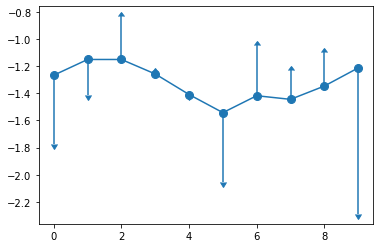

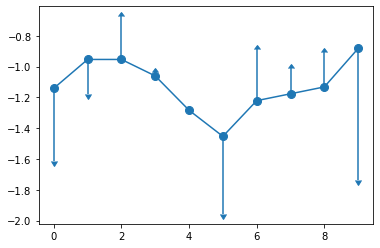

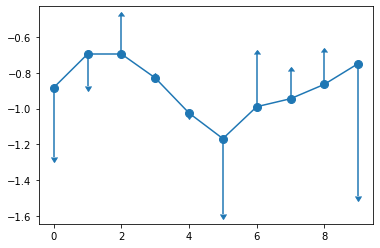

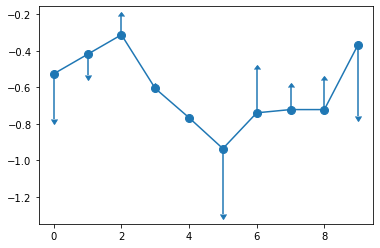

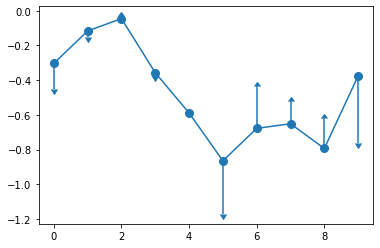

In [62]:
#since the data is given monthly, we can use a step size of 12 to compare the same month in different years
#plt.figsize(8,8)
plt.figure()
for x in range(5,54,12):
  model_in=feature_tensor[x]
  y_data=model_in.detach().numpy()
  x_data=np.arange(len(y_data))
  attributions,_=get_attr(model,model_in.unsqueeze(0))
  #plt.plot(x_data,y_data)
  #plt.show()
  viz_input_importance(x_data,y_data,attributions)
  #print(model(model_in), target_tensor[x])

plt.show()

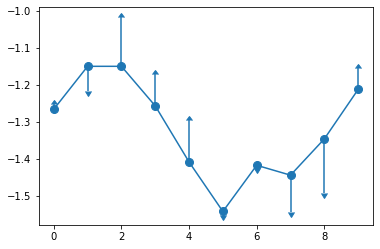

tensor([-1.1696], grad_fn=<AddBackward0>)


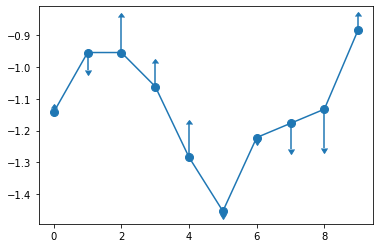

tensor([-0.9916], grad_fn=<AddBackward0>)


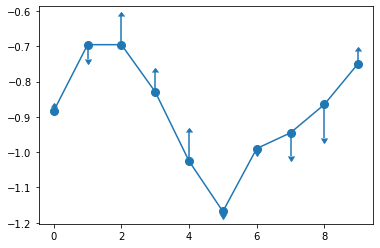

tensor([-0.8604], grad_fn=<AddBackward0>)


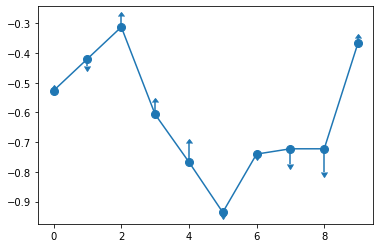

tensor([-0.4592], grad_fn=<AddBackward0>)


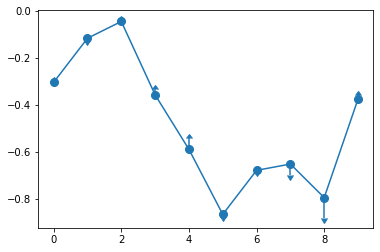

tensor([-0.3012], grad_fn=<AddBackward0>)


In [63]:
random_model=RegModel()
for x in range(5,54,12):
  model_in=feature_tensor[x]
  y_data=model_in.detach().numpy()
  x_data=np.arange(len(y_data))
  attributions,_=get_attr(random_model,model_in.unsqueeze(0))
  #plt.plot(x_data,y_data)
  #plt.show()
  viz_input_importance(x_data,y_data,attributions,magnify_factor=10)
  print(model(model_in))

# Run some more experiments with a CNN model:

In [64]:
#define another network, loss function and optimizer

class CNNModel(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1=nn.Conv1d(kernel_size=3,in_channels=1,out_channels=3)
    #self.lin1=nn.Linear(10,3)
    self.flat=nn.Flatten()
    self.lin1=nn.Linear(24,3)
    self.sig1=nn.Sigmoid()
    self.lin2=nn.Linear(3,1)
    

  def forward(self,x):
    z=self.conv1(x)
    z=self.flat(z)
    z=self.lin1(z)
    z=self.sig1(z)
    z=self.lin2(z)
    return z

cnmodel=CNNModel()
loss_func = nn.MSELoss()
opt = optim.Adam(cnmodel.parameters(),lr=0.00001)

In [65]:
import copy
epochs=250000
best_val_loss=10**10

for epoch in range(epochs):
  pred=cnmodel(train_f.unsqueeze(1)).squeeze()
  loss=loss_func(pred,train_t)
  loss.backward()
  opt.step()

  #calculate validation loss
  val_loss=loss_func(cnmodel(val_f.unsqueeze(1)).squeeze(),val_t)

  if val_loss<best_val_loss:
    if best_val_loss - val_loss > 0.01:
      best_cnmodel=copy.deepcopy(cnmodel)
    inc_count=0
    best_val_loss=val_loss
  else:
    inc_count+=1
  if inc_count >525:
    #cnmodel=best_cnmodel
    break

  cnmodel.zero_grad()
  if epoch%(epochs/100) == 0:
    print('training loss: ',loss,'  validation loss: ',val_loss)

training loss:  tensor(1.1475, grad_fn=<MseLossBackward>)   validation loss:  tensor(1.6069, grad_fn=<MseLossBackward>)
training loss:  tensor(1.0687, grad_fn=<MseLossBackward>)   validation loss:  tensor(1.5285, grad_fn=<MseLossBackward>)
training loss:  tensor(0.9904, grad_fn=<MseLossBackward>)   validation loss:  tensor(1.4325, grad_fn=<MseLossBackward>)
training loss:  tensor(0.8933, grad_fn=<MseLossBackward>)   validation loss:  tensor(1.3019, grad_fn=<MseLossBackward>)
training loss:  tensor(0.7773, grad_fn=<MseLossBackward>)   validation loss:  tensor(1.1375, grad_fn=<MseLossBackward>)
training loss:  tensor(0.6640, grad_fn=<MseLossBackward>)   validation loss:  tensor(0.9723, grad_fn=<MseLossBackward>)
training loss:  tensor(0.5698, grad_fn=<MseLossBackward>)   validation loss:  tensor(0.8304, grad_fn=<MseLossBackward>)
training loss:  tensor(0.4982, grad_fn=<MseLossBackward>)   validation loss:  tensor(0.7182, grad_fn=<MseLossBackward>)
training loss:  tensor(0.4463, grad_fn=<

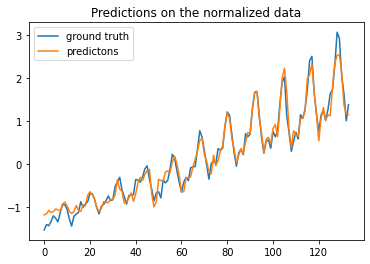

In [66]:
#visualize model performance

full_predictions=cnmodel(feature_tensor.unsqueeze(1)).detach()
full_predictions=full_predictions.squeeze(-1).squeeze(-1)
import matplotlib.pyplot as plt

plt.plot(target_tensor,label='ground truth')
plt.plot(full_predictions,label='predictons')
plt.title('Predictions on the normalized data')
plt.legend()
plt.show()

In [67]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

cap_input=train_f[0].unsqueeze(0).unsqueeze(0)
cap_input.requires_grad=True
cap_target=train_t[0].unsqueeze(0)
print(cap_input.shape,cap_target.shape)

torch.Size([1, 1, 10]) torch.Size([1])


In [68]:
#define some convenience functions for the different methods
#vgl. https://captum.ai/tutorials/CIFAR_TorchVision_Interpret

def get_attr_saliency(vmodel):
  vmodel.zero_grad()
  saliency = Saliency(vmodel)
  sal_grads = saliency.attribute(cap_input)
  return sal_grads.squeeze(0).squeeze(0)

def get_attr_ig(vmodel):
  vmodel.zero_grad()
  ig = IntegratedGradients(vmodel)
  attr_ig, delta = ig.attribute(cap_input, baselines=cap_input * 0, return_convergence_delta=True)
  return attr_ig.squeeze(0).squeeze(0)


def get_attr_nt(vmodel):
  vmodel.zero_grad()
  ig = IntegratedGradients(vmodel)
  nt = NoiseTunnel(ig)
  attr_ig_nt = nt.attribute(cap_input, baselines=cap_input * 0, nt_type='smoothgrad_sq',
                                        nt_samples=100, stdevs=0.2)
  return attr_ig_nt.squeeze(0).squeeze(0)


def get_attr_dl(vmodel):
  vmodel.zero_grad()
  dl = DeepLift(vmodel)
  attr_dl = dl.attribute(cap_input, baselines=cap_input * 0)
  return attr_dl.squeeze(0).squeeze(0)


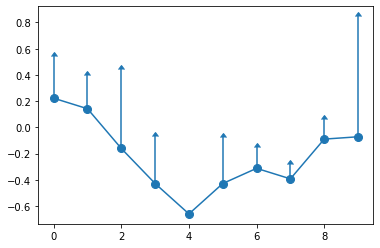

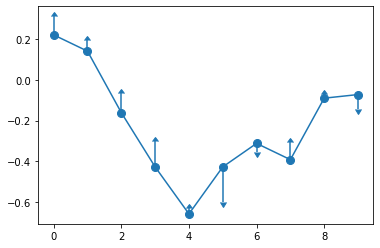

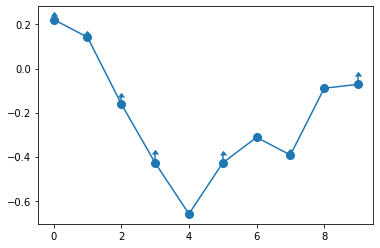

/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


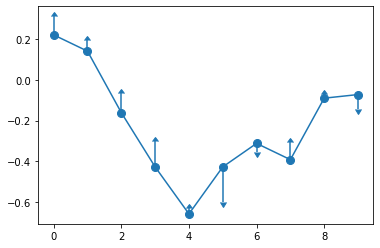

In [69]:
for method in [get_attr_saliency, get_attr_ig, get_attr_nt, get_attr_dl]:

  attr=method(cnmodel)
  y_data=cap_input.squeeze(0).squeeze(0).detach()
  x_data=np.arange(len(y_data))

  viz_input_importance(x_data,y_data,attr)